## Testing the DL algorithm for R-peak detection - DOI: 10.1109/TIM.2023.3241997

In [1]:
import os
import numpy as np
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
from customLib.vis import *
from customLib.preprocess import *
from customLib.load_physionet_ecgs import load_physionet_ecgs
from customLib.dataset import split_dataset
from customLib.config import mitbih_path

Constants for the notebook

### Downloading and preprocess of the MIT-BIH Arrhythmia dataset 
I removed the original annotation file for 102 recording - file 102-0.atr

In [3]:
# ! wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/ -P "E:\\ml-data\\masters-thesis\\mitbih\\"

In [2]:
# Get all file names of the recordings / annotations
fileNames = [ x.split(".")[0] for x in os.listdir(mitbih_path) if x.endswith(".atr") ]

In the original paper, authors discard the recordings containing pacemaker hearbeats. To reproduce the results, the same action will be performed.

In [3]:
filteredFileNames = []

for fileName in fileNames:
  filePath = os.path.join(mitbih_path, fileName)
  annotation = wfdb.rdann(filePath, 'atr')
  annotationSymbols = annotation.symbol
  if '/' not in annotationSymbols:
    filteredFileNames.append(fileName)
  else:
    print(f"Dropping recoring {fileName}")

Dropping recoring 102-0
Dropping recoring 102
Dropping recoring 104
Dropping recoring 107
Dropping recoring 217


Using all of the labels for all R-peaks, no matter the illness label


In [6]:
# help(wfdb.Record) | help(wfdb.Annotation)

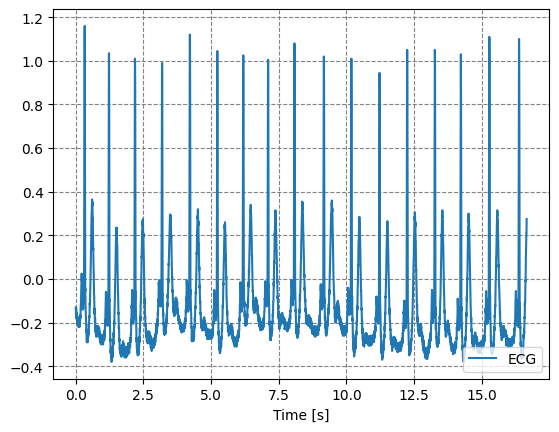

In [4]:
file = os.path.join(mitbih_path, "106")

record = wfdb.rdrecord(file, sampfrom=100000, sampto=160000, channels=[0])
annotation = wfdb.rdann(file, 'atr', sampto=6000)
final_annotations = np.unique(annotation.sample[np.in1d(annotation.symbol, ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', 'f', 'Q', '?'])])
ECG = record.p_signal[:6000, 0]
plot_ecg(ECG, fs=360)

### ECG denoising using wavelet transform
In the paper, authors ignore the D1, D2, D8 and D9 components of the wavelet decomposition (https://doi.org/10.1016/j.dsp.2005.12.003). The same action will be performed.

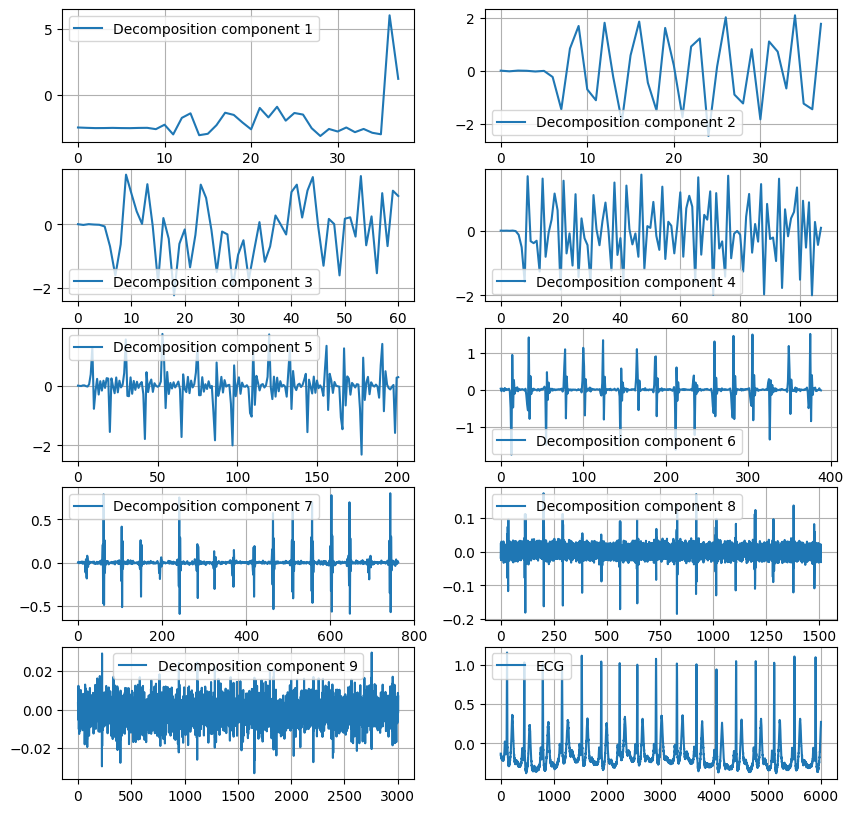

In [15]:
plot_dwt(ECG)

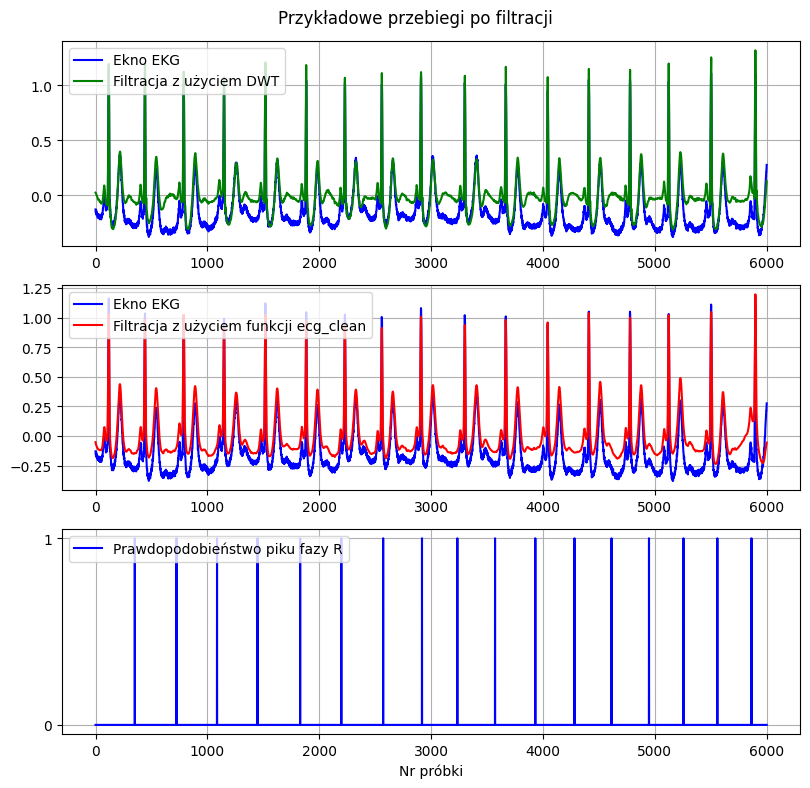

In [32]:
denoised_ecg = dwt_denoise(ECG)
r_peaks_signal = np.zeros_like(ECG)
r_peaks_signal[final_annotations] = 1

plt.figure(figsize=(8,8))
plt.suptitle("Przykładowe przebiegi po filtracji")
plt.subplot(3,1,1)
plt.plot(ECG, 'b-')
plt.plot(denoised_ecg, 'g-')
#plt.plot(r_peaks_signal)
plt.legend(["Ekno EKG", "Filtracja z użyciem DWT"], loc="upper left")
plt.grid()
plt.subplot(3,1,2)
plt.plot(ECG, 'b-')
plt.plot(nk.ecg_clean(ECG, sampling_rate=360), 'r-')
plt.legend(["Ekno EKG", "Filtracja z użyciem funkcji ecg_clean"], loc="upper left")
plt.grid()
plt.subplot(3,1,3)
plt.yticks([0,1], [0,1])
plt.plot(r_peaks_signal, 'b-')
plt.legend(["Prawdopodobieństwo piku fazy R"], loc="upper left")
plt.grid()
plt.xlabel("Nr próbki")
plt.tight_layout()


As this is not mentioned in the original paper, I will use all available channels and treat them as different samples. Final function in the customLib/load_physionet_ecg.py

In [2]:
x , y = load_physionet_ecgs(path=mitbih_path, force_new=True, window_in_seconds=10, normalize=True, denoise=True, smoothen=True, expand=False)

Dropping recording 102-0
Dropping recording 102
Dropping recording 104
Dropping recording 107
Dropping recording 217
ECGs sampling rate:  360


  0%|          | 0/44 [00:00<?, ?it/s]

File:  100


  2%|▏         | 1/44 [00:02<01:45,  2.46s/it]

File:  101


  5%|▍         | 2/44 [00:04<01:42,  2.45s/it]

File:  103


  7%|▋         | 3/44 [00:07<01:38,  2.41s/it]

File:  105


  9%|▉         | 4/44 [00:09<01:36,  2.42s/it]

File:  106


 11%|█▏        | 5/44 [00:12<01:34,  2.42s/it]

File:  108


 14%|█▎        | 6/44 [00:14<01:34,  2.48s/it]

File:  109


 16%|█▌        | 7/44 [00:17<01:31,  2.48s/it]

File:  111


 18%|█▊        | 8/44 [00:19<01:28,  2.47s/it]

File:  112


 20%|██        | 9/44 [00:22<01:25,  2.44s/it]

File:  113


 23%|██▎       | 10/44 [00:24<01:23,  2.45s/it]

File:  114


 25%|██▌       | 11/44 [00:26<01:20,  2.43s/it]

File:  115


 27%|██▋       | 12/44 [00:29<01:18,  2.44s/it]

File:  116


 30%|██▉       | 13/44 [00:31<01:15,  2.44s/it]

File:  117


 32%|███▏      | 14/44 [00:34<01:12,  2.43s/it]

File:  118


 34%|███▍      | 15/44 [00:36<01:10,  2.43s/it]

File:  119


 36%|███▋      | 16/44 [00:39<01:08,  2.45s/it]

File:  121


 39%|███▊      | 17/44 [00:41<01:06,  2.46s/it]

File:  122


 41%|████      | 18/44 [00:44<01:04,  2.47s/it]

File:  123


 43%|████▎     | 19/44 [00:46<01:01,  2.47s/it]

File:  124


 45%|████▌     | 20/44 [00:49<01:00,  2.50s/it]

File:  200


 48%|████▊     | 21/44 [00:51<00:57,  2.50s/it]

File:  201


 50%|█████     | 22/44 [00:54<00:55,  2.51s/it]

File:  202


 52%|█████▏    | 23/44 [00:56<00:52,  2.51s/it]

File:  203


 55%|█████▍    | 24/44 [00:59<00:50,  2.51s/it]

File:  205


 57%|█████▋    | 25/44 [01:01<00:47,  2.51s/it]

File:  207


 59%|█████▉    | 26/44 [01:04<00:45,  2.53s/it]

File:  208


 61%|██████▏   | 27/44 [01:06<00:43,  2.54s/it]

File:  209


 64%|██████▎   | 28/44 [01:09<00:40,  2.53s/it]

File:  210


 66%|██████▌   | 29/44 [01:11<00:38,  2.55s/it]

File:  212


 68%|██████▊   | 30/44 [01:14<00:37,  2.66s/it]

File:  213


 70%|███████   | 31/44 [01:17<00:34,  2.68s/it]

File:  214


 73%|███████▎  | 32/44 [01:20<00:32,  2.70s/it]

File:  215


 75%|███████▌  | 33/44 [01:23<00:30,  2.75s/it]

File:  219


 77%|███████▋  | 34/44 [01:25<00:27,  2.73s/it]

File:  220


 80%|███████▉  | 35/44 [01:28<00:24,  2.70s/it]

File:  221


 82%|████████▏ | 36/44 [01:31<00:21,  2.69s/it]

File:  222


 84%|████████▍ | 37/44 [01:33<00:19,  2.72s/it]

File:  223


 86%|████████▋ | 38/44 [01:36<00:16,  2.74s/it]

File:  228


 89%|████████▊ | 39/44 [01:39<00:13,  2.74s/it]

File:  230


 91%|█████████ | 40/44 [01:42<00:11,  2.76s/it]

File:  231


 93%|█████████▎| 41/44 [01:45<00:08,  2.74s/it]

File:  232


 95%|█████████▌| 42/44 [01:47<00:05,  2.75s/it]

File:  233


 98%|█████████▊| 43/44 [01:50<00:02,  2.80s/it]

File:  234


100%|██████████| 44/44 [01:53<00:00,  2.58s/it]


## Resampling ECGs -> downsampling from 360 to 100 Hz

In [26]:
# x , y = load_physionet_ecgs(path=mitbih_path, force_new=True, window_in_seconds=10, expand=False, denoise=True)

x = np.load(mitbih_path + "\\preprocessed\\x.npy")
y = np.load(mitbih_path + "\\preprocessed\\y.npy")

# downsample signals
res_x = []
res_y = []

for i in range(x.shape[0]):
  res_x.append(resample_signal(x[i], 1000))

for i in range(y.shape[0]):
 res_y.append(downsample_r_peaks_probability(r_peaks_probability=y[i], original_fs=360, target_fs=100))

#res_y = expand_labels(res_y, left_shift=5, right_shift=6)
res_x = np.array(res_x)
res_y = np.array(res_y)

np.save(mitbih_path + "\\preprocessed\\downsampled\\x.npy", res_x)
np.save(mitbih_path + "\\preprocessed\\downsampled\\y.npy", res_y)

path = mitbih_path + "\\dataset\\downsampled"
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(res_x, res_y, split_ratio=0.75, shuffle=True, is_validation_set=True, path=path)

Total ECGs: 15840
Saving dataset to: 
 E:\ml-data\masters-thesis\physionet.org\files\mitdb\1.0.0\dataset\downsampled


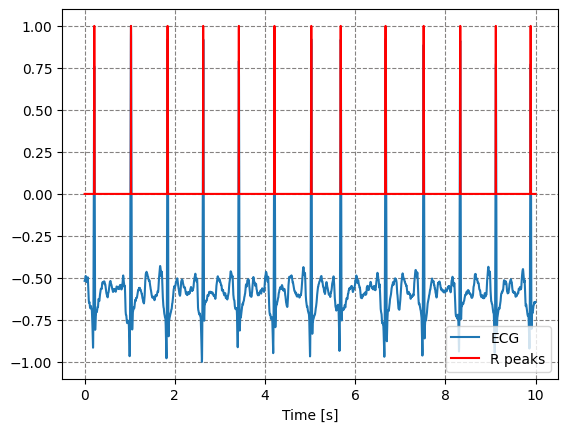

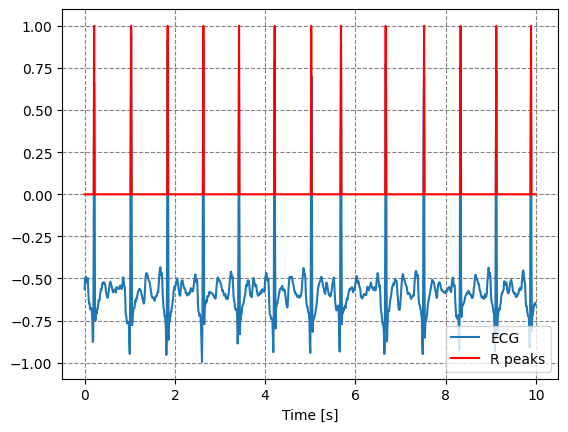

X shape before resample:  (15840, 3600)
X shape after resample:  (15840, 1000)


In [27]:
plot_ecg(x[0], y[0], 360)
plot_ecg(res_x[0], res_y[0], 100)

print("X shape before resample: ", x.shape)
print("X shape after resample: ", res_x.shape)

In [28]:
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_test shape: ", y_test.shape)
print("X_val shape: ", x_val.shape)
print("Y_val shape: ", y_val.shape)

X_train shape:  (11880, 1000)
Y_train shape:  (11880, 1000)
X_test shape:  (3960, 1000)
Y_test shape:  (3960, 1000)
X_val shape:  (1980, 1000)
Y_val shape:  (1980, 1000)
